# Is it possible to determine white wine quality based on its attributes?

## Introduction:

Wine is an alcoholic drink made from fermenting grapes or other fruits. It has many attributes that differ in composition, which gives each wine its own unique characteristics. The attributes of wine are typically measured as part of the wine manufacturing process. It ensures the wine is absent of harmful impurities and is safe to consume. These attributes include:

- fixed acidity (g(tartaric acid)/dm^3)
- volatile acidity (g(acetic acid)/dm^3)
- citric acid (g/dm^3)
- residual sugar (g/dm^3)
- chlorides (g(sodium chloride)/dm^3)
- free sulfur dioxide (mg/dm^3)
- total sulfur dioxide (mg/dm^3)
- density (g/cm^3)
- pH
- sulphates (g(potassium sulphate)/dm^3)
- alcohol (vol.%)

Quality, which is typically determined by professional wine tasters, could be affected by these attributes of wine. The goal of our project is to answer the following question: is it possible to determine white wine quality based on its attributes?

To answer this question, we will be using the Wine Quality dataset from the UC Irvine Machine Learning Repository which can be accessed [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). There are two datasets to choose from: red wine and white wine. We chose the white wine dataset since it has more observations than the red wine dataset. The dataset includes the attributes listed above and a quality rating from 0 to 10 for each wine.

## Methods:

To answer our question, we will conduct our data analysis by using the $K$-nearest neighbours classification model and 5-fold cross validation to select our $K$ value. The predictors we will use are volatile acidity and alcohol. Quality will be our target variable for this model. We decided to use these variables after researching which components of white wine may affect its quality, and concluded that volatile acidity and alcohol were reoccurring variables seen in the [sources](#Sources:) we looked at. We will visualize the results of our project using scatter plots, line plots, and tables. 

## Preliminary exploratory data analysis:

### Loading, Cleaning, and Wrangling

In [1]:
# Loading libraries required for notebook

library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 11)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

After loading libraries, we can load, clean, and tidy the dataset. We can read the dataset from the internet using R and clean it by converting the quality column to a factor and removing spaces from the column names.

In [2]:
wine_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", 
                        delim = ";", show_col_types = FALSE) |>
    mutate(quality = as_factor(quality))

colnames(wine_data) <- make.names(colnames(wine_data))

paste("Table 1: White wine data before split")
wine_data

[1] "Table 1: White wine data before split"

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.50,11.2,6
6.6,0.32,0.36,8.0,0.047,57,168,0.99490,3.15,0.46,9.6,5


There are no missing or N/A values in our dataset.

In [3]:
cat("Number of missing values:", sum(is.na(wine_data)))

Number of missing values: 0

The seed is set so that ```initial_split``` always produces the same result, and split the data such that 75% of the data is for training, while 25% is for testing.

In [4]:
set.seed(1234) # setting seed for reproducibility

wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split) 

### Tables

Table 2 shows the number of observations for each class using ```group_by``` and ```summarize```, and Table 3 shows the mean, median, minimum, and maximum values for each predictor of the training dataset.

In [5]:
observation_counts <- wine_train |>
    group_by(quality) |>
    summarize(count = n())

paste("Table 2: Number of observations for each class")
observation_counts

pred_stats_table <- wine_train |>
    select(-quality) |>
    pivot_longer(cols = fixed.acidity:alcohol, names_to = "key", values_to = "value") |> 
    group_by(key) |>
    summarize(mean = mean(value), median = median(value), min = min(value), max = max(value))

paste("Table 3: Summary of training dataset")
pred_stats_table

[1] "Table 2: Number of observations for each class"

quality,count
<fct>,<int>
3,14
4,121
5,1091
6,1650
7,665
8,129
9,3


[1] "Table 3: Summary of training dataset"

key,mean,median,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
alcohol,10.50555132,10.4000,8.00000,14.05000
chlorides,0.04569289,0.0430,0.00900,0.34600
citric.acid,0.33459025,0.3200,0.00000,1.66000
density,0.99407305,0.9938,0.98711,1.03898
fixed.acidity,6.85144296,6.8000,3.80000,14.20000
free.sulfur.dioxide,35.21753335,34.0000,2.00000,289.00000
pH,3.18849442,3.1700,2.74000,3.82000
residual.sugar,6.46768309,5.4000,0.60000,65.80000
sulphates,0.48907433,0.4700,0.22000,1.08000


### Visualizations

In Figure 1, the distribution of the number of observations for each class is skewed slightly to the left, and a quality score of 6 was the most common. In this dataset, there are only observations with a quality of 3 to 9, rather than from 0 to 10.

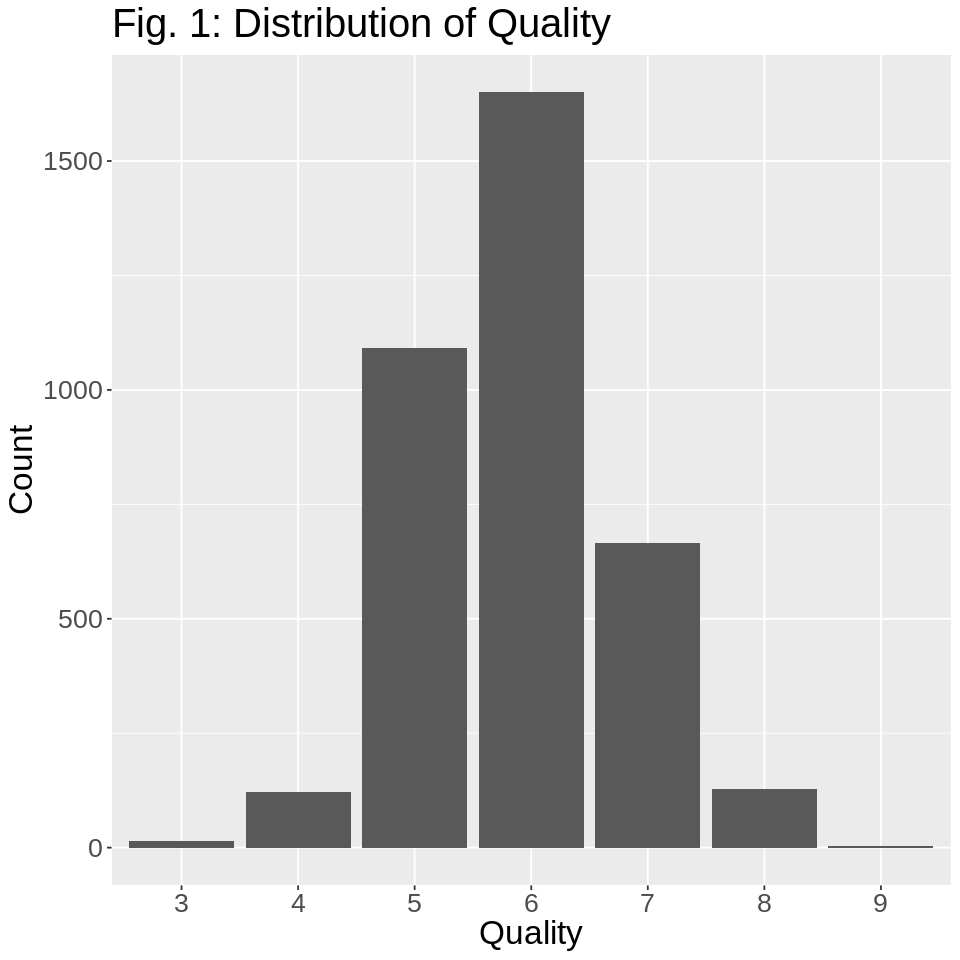

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)

observation_plot <- wine_train |>
    ggplot(aes(x = quality)) +
    geom_bar() +
    theme(text = element_text(size = 20)) + 
    ggtitle("Fig. 1: Distribution of Quality") +
    labs(x = "Quality", y = "Count")

observation_plot

After plotting the distributions of each predictor variable in Figure 2, we see that some variables have narrow distributions (chlorides, citric acid), some variables have broad distributions (pH, sulphates), and one variable is spread out (alcohol).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



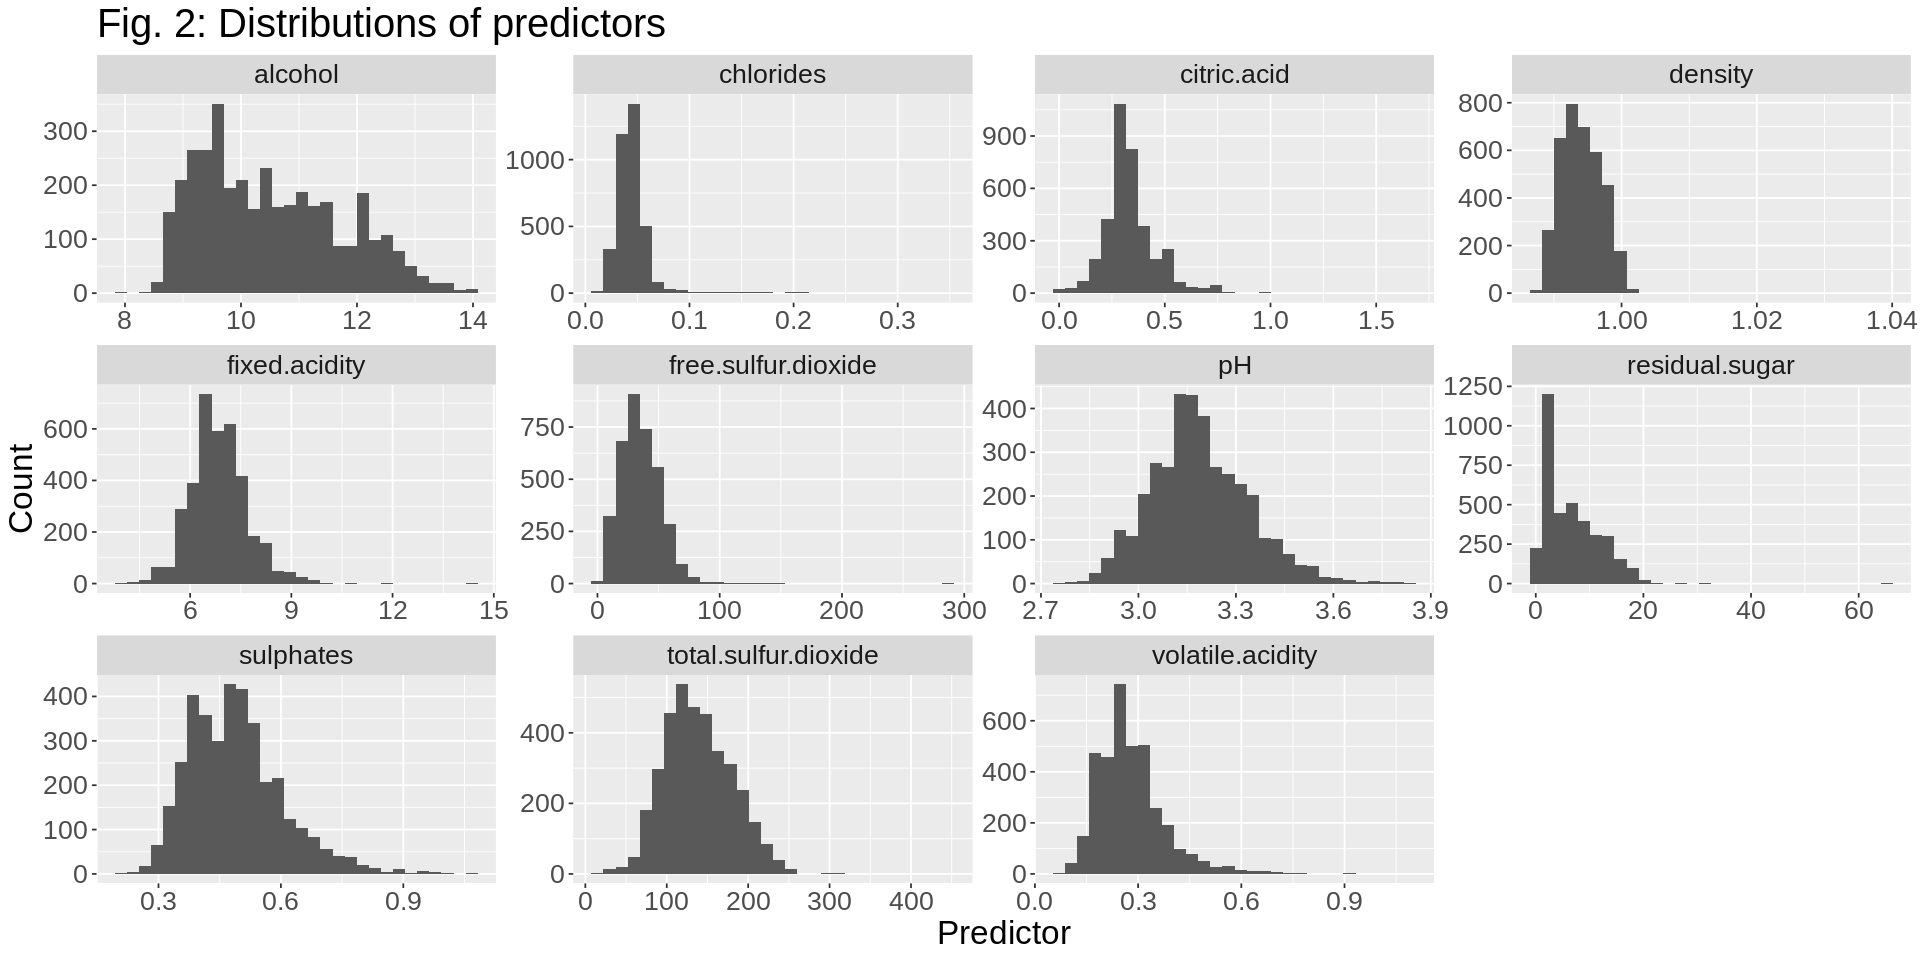

In [7]:
options(repr.plot.width = 16, repr.plot.height = 8)

pred_dist_plot <- wine_train |>
    select(-quality) |>
    pivot_longer(cols = fixed.acidity:alcohol, names_to = "key", values_to = "value") |> 
    mutate(value = as.double(value)) |> 
    ggplot(aes(x = value)) + 
    geom_histogram() +
    facet_wrap(~ key, scales = "free") +
    theme(text = element_text(size = 20)) + 
    labs(x = "Predictor", y = "Count", title = "Fig. 2: Distributions of predictors")

pred_dist_plot

In Figure 3, there appears to be a weak but slightly positive relationship between alcohol content and quality.

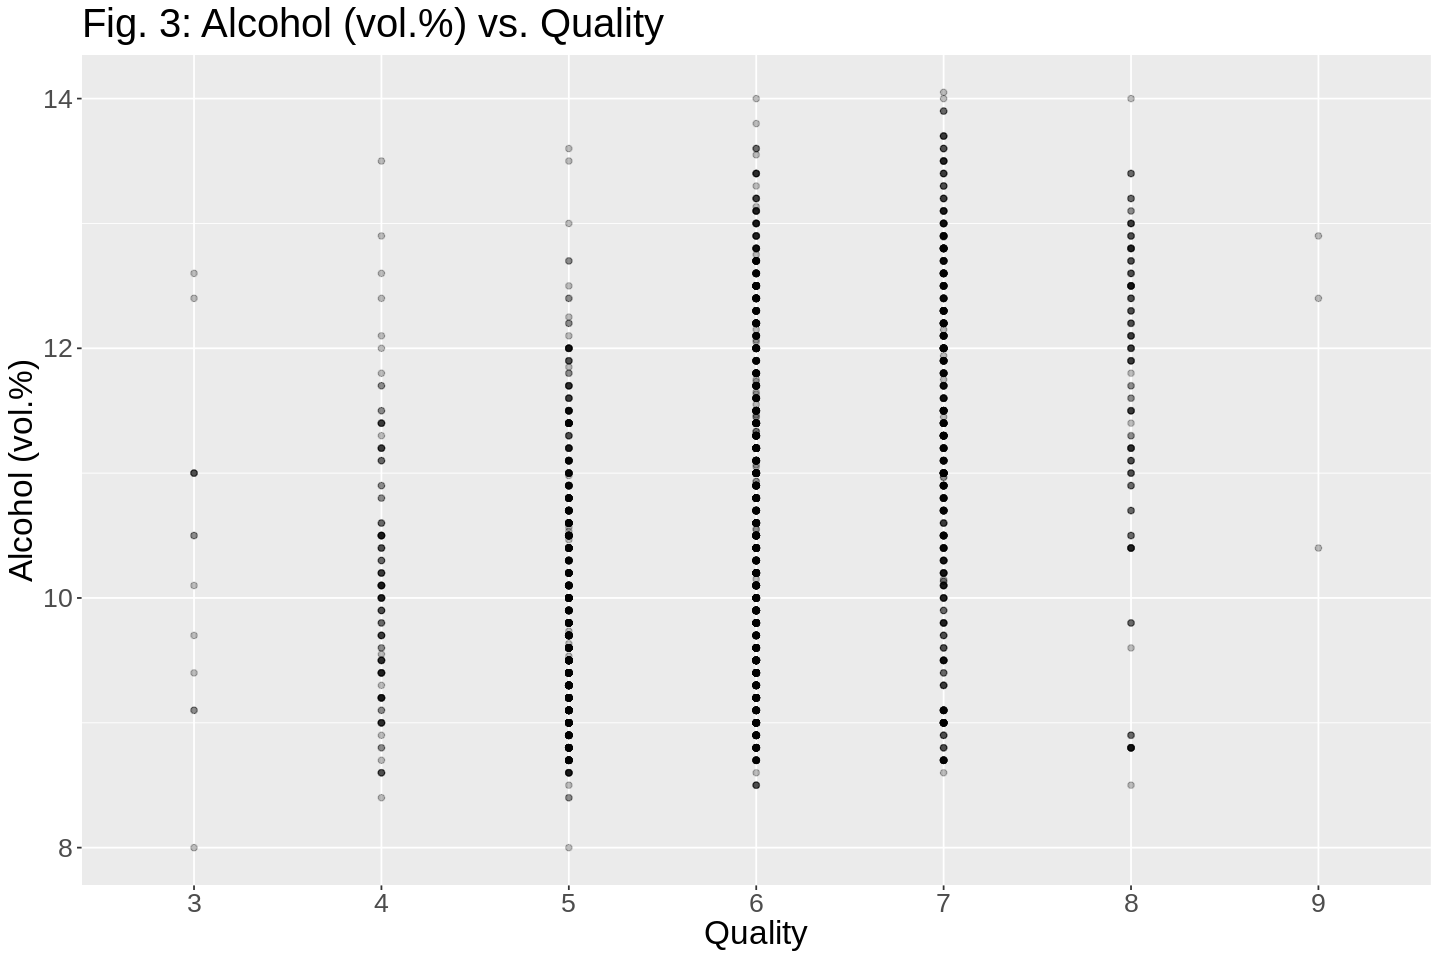

In [18]:
options(repr.plot.width = 12, repr.plot.height = 8)

alcohol_vs_quality_plot <- wine_train |>
    ggplot(aes(x = quality, y = alcohol)) + 
    geom_point(alpha = 0.25) +
    theme(text = element_text(size = 20)) + 
    labs(x = "Quality", y = "Alcohol (vol.%)", title = "Fig. 3: Alcohol (vol.%) vs. Quality")

alcohol_vs_quality_plot

Using the ```ggpairs``` function from the GGAlly library, we can make a correlation matrix to get some insight on what variables we may need to use for training our model.

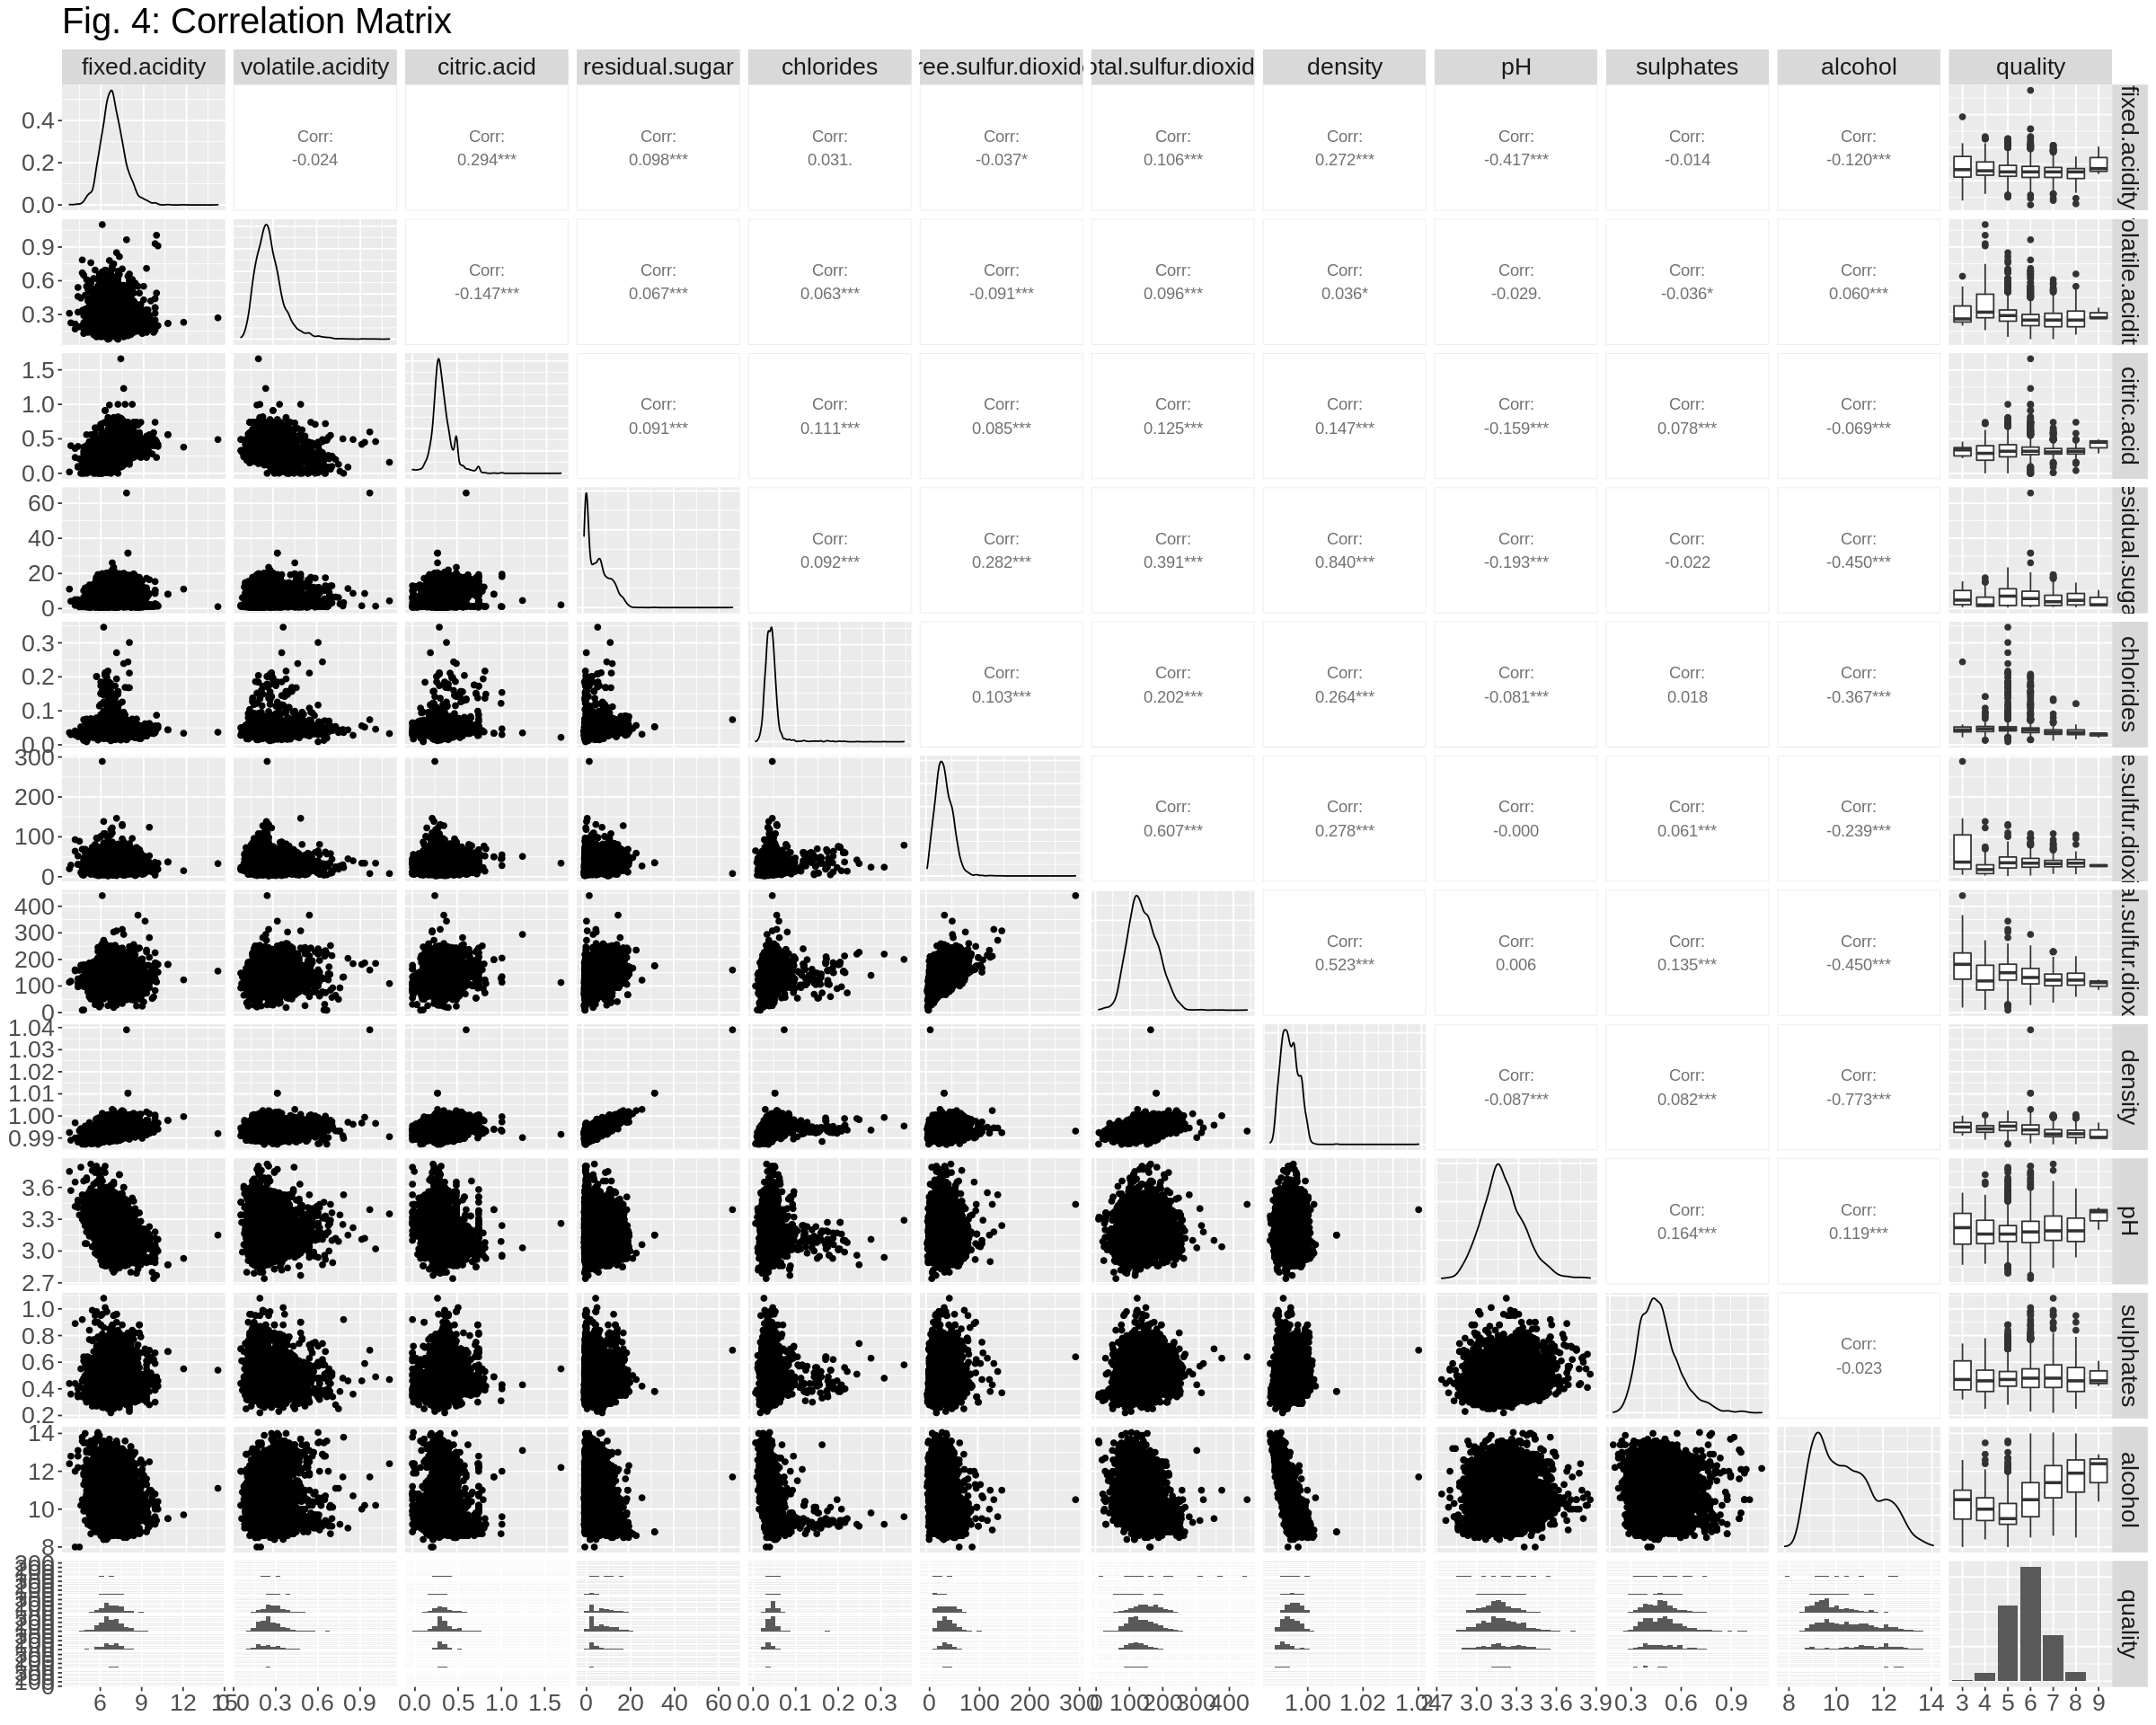

In [19]:
options(repr.plot.width = 20, repr.plot.height = 16)

correlation_plot <- wine_train |>
    ggpairs(title = "Fig. 4: Correlation Matrix") +
    theme(text = element_text(size = 20))

suppressMessages(print(correlation_plot)) # remove messages about binwidth

### Classification

First, we will pre-process the data by standardizing the data, and then use 5-fold cross validation to select a value for K.

In [10]:
wine_recipe <- recipe(quality ~ volatile.acidity + alcohol, data = wine_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [11]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

In [12]:
set.seed(1234)

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

In [13]:
set.seed(1234)

gridvals = tibble(neighbors = seq(from = 1, to = 201, by = 10))

wine_tune <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = gridvals)

! Fold3: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): '9'
  Computation will proceed by ignoring those levels.



In [14]:
results <- wine_tune |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))

results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
51,accuracy,multiclass,0.5360815,5,0.004704955,Preprocessor1_Model06
91,accuracy,multiclass,0.5314534,5,0.005378276,Preprocessor1_Model10
81,accuracy,multiclass,0.5314508,5,0.005044605,Preprocessor1_Model09
41,accuracy,multiclass,0.5309040,5,0.004750810,Preprocessor1_Model05
61,accuracy,multiclass,0.5298159,5,0.006043389,Preprocessor1_Model07
101,accuracy,multiclass,0.5287253,5,0.004355704,Preprocessor1_Model11
⋮,⋮,⋮,⋮,⋮,⋮,⋮
121,accuracy,multiclass,0.5213758,5,0.003485807,Preprocessor1_Model13
201,accuracy,multiclass,0.5213732,5,0.004795318,Preprocessor1_Model21


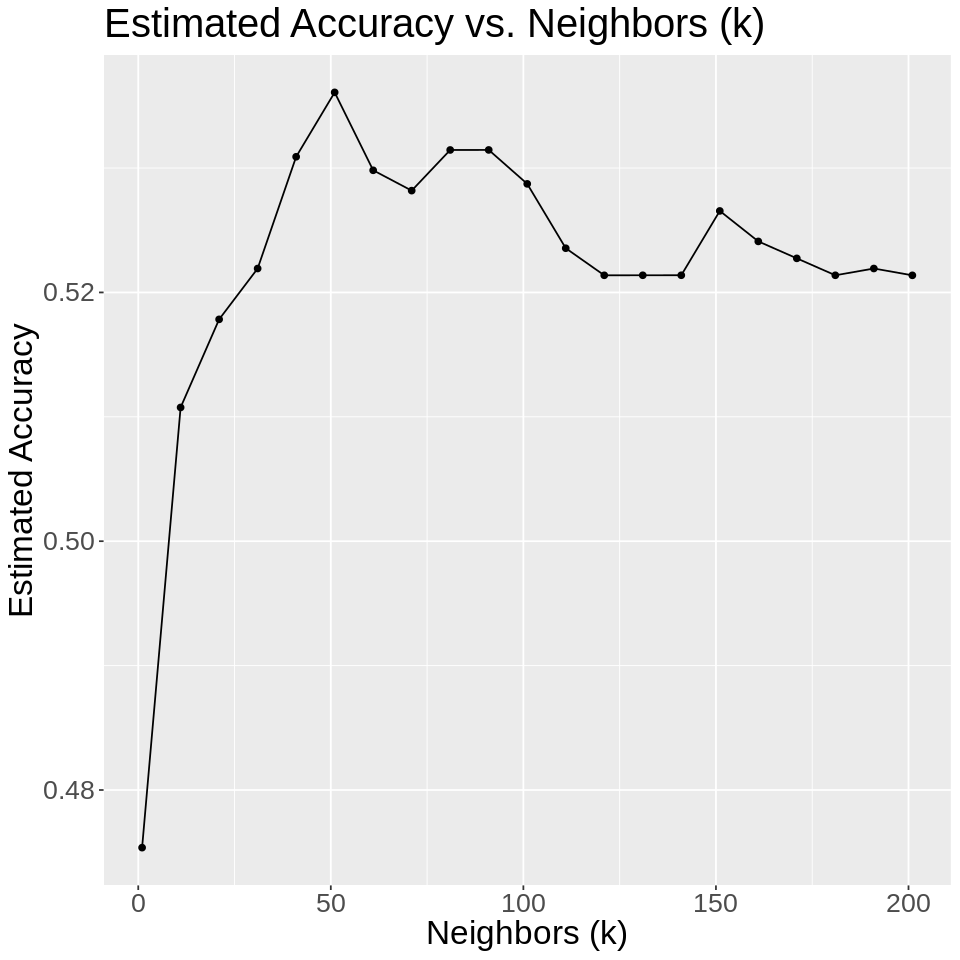

In [21]:
options(repr.plot.width = 8, repr.plot.height = 8)

accuracy_plot <- results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Neighbors (k)", y = "Estimated Accuracy", title = "Estimated Accuracy vs. Neighbors (k)") +
    theme(text = element_text(size = 20))

accuracy_plot

In [16]:
knn_fit <- nearest_neighbor(weight_func = "rectangular", neighbors = 51) |>
    set_engine("kknn") |>
    set_mode("classification")

In [17]:
wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_fit) |>
    fit(data = wine_train)

## Discussion:

## Expected outcomes and significance:

We expect to find that white wine quality can be determined using our chosen predictors. These findings could help wine manufacturers improve their production processes for white wine, as knowing which attributes affect its perceived quality can help fine-tune specific components of the wine-making process. This could lead to future questions such as whether or not other components of wine that were not in the data set could affect white wine quality (grape type, grape size), if external factors can affect white wine quality (environment, harvesting, fermentation), and if a perfect white wine can be made by tuning the correct attributes.

## Sources:

Jakabová, S., Fikselová, M., Mendelová, A., Ševčík, M., Jakab, I., Aláčová, Z., Kolačkovská, J., & Ivanova-Petropulos, V. (2021). Chemical composition of white wines produced from different grape varieties and wine regions in slovakia. Applied Sciences, 11(22), 11059. https://doi.org/10.3390/app112211059

Liguori, L., Albanese, D., Crescitelli, A., Di Matteo, M., & Russo, P. (2019). Impact of dealcoholization on quality properties in white wine at various alcohol content levels. Journal of food science and technology, 56(8), 3707–3720. https://doi.org/10.1007/s13197-019-03839-x

Sharma, A. K., Singh, P. N., & Sawant, S. D. (2012). Evaluation of Fermentation Efficiency of Yeast Strains and their Effect on Quality of Young Wines. Indian journal of microbiology, 52(3), 495–499. https://doi.org/10.1007/s12088-011-0226-y 